In [126]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

import acquire_zillow
from acquire_zillow import get_connection
from acquire_zillow import get_properties_2016
from acquire_zillow import get_properties_2017
from acquire_zillow import get_zillow_csv

import prepare_zillow
from prepare_zillow import reindex_zillow
from prepare_zillow import drop_land_listings
from prepare_zillow import convert_num_to_categorical
from prepare_zillow import convert_numerical_object_to_int

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn import linear_model

import scipy.stats as stats
from scipy.stats import pearsonr

from mpl_toolkits.mplot3d import Axes3D

import graphviz
from graphviz import Graph

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

random_state=123

import env

In [2]:
df = pd.read_fwf('curr_access.txt', delimiter=' ')
df.head(15)

,2018-01-26,09:55:03,/ 1 8 97.105.19.61,Unnamed: 3
0,2018-01-26,09:56:02,java-ii 1 8 97.105.19.61,NaN
1,2018-01-26,09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN
2,2018-01-26,09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN
3,2018-01-26,09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN
4,2018-01-26,09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN
5,2018-01-26,09:56:46,javascript-i/conditionals 3 22 97.105.19.61,NaN
6,2018-01-26,09:56:48,javascript-i/functions 3 22 97.105.19.61,NaN
7,2018-01-26,09:56:59,javascript-i/loops 2 22 97.105.19.61,NaN
8,2018-01-26,09:58:26,javascript-i/functions 4 22 97.105.19.61,NaN
9,2018-01-26,09:59:22,mkdocs/search_index.json 5 22 97.105.19.61,NaN


In [3]:
df.shape

(233527, 4)

In [4]:
df.rename(index=str, columns={'2018-01-26':'date', '09:55:03':'time', '/ 1 8 97.105.19.61':'stuff'}, inplace=True)

In [5]:
df['program'], df['user'], df['cohort'], df['ip'] = df['stuff'].str.split(' ').str

In [6]:
df.head(15)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip
0,2018-01-26,09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61
1,2018-01-26,09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61
2,2018-01-26,09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61
3,2018-01-26,09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN,javascript-i/conditionals,2,22,97.105.19.61
4,2018-01-26,09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61
5,2018-01-26,09:56:46,javascript-i/conditionals 3 22 97.105.19.61,NaN,javascript-i/conditionals,3,22,97.105.19.61
6,2018-01-26,09:56:48,javascript-i/functions 3 22 97.105.19.61,NaN,javascript-i/functions,3,22,97.105.19.61
7,2018-01-26,09:56:59,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61
8,2018-01-26,09:58:26,javascript-i/functions 4 22 97.105.19.61,NaN,javascript-i/functions,4,22,97.105.19.61
9,2018-01-26,09:59:22,mkdocs/search_index.json 5 22 97.105.19.61,NaN,mkdocs/search_index.json,5,22,97.105.19.61


In [7]:
df.dtypes

date          object
time          object
stuff         object
Unnamed: 3    object
program       object
user          object
cohort        object
ip            object
dtype: object

In [8]:
df[df.ip.str.len() < 7]

,date,time,stuff,Unnamed: 3,program,user,cohort,ip
886,2018-01-28,16:16:57,content/php_i/types-and-variables-i/introducti...,179.161.39,content/php_i/types-and-variables-i/introducti...,51,13,72
2152,2018-01-30,12:45:42,content/php_iv/classes-and-objects-ii/gitbook/...,.171.117.210,content/php_iv/classes-and-objects-ii/gitbook/...,69,14,19
2410,2018-01-30,20:30:19,content/php_i/types-and-variables-i/introducti...,179.161.39,content/php_i/types-and-variables-i/introducti...,51,13,72
3684,2018-02-01,14:09:08,content/mysql/aliases-and-functions/gitbook/im...,5.19.61,content/mysql/aliases-and-functions/gitbook/im...,70,19,97.1
7782,2018-02-09,12:11:38,content/php_iv/classes-and-objects-ii/gitbook/...,197.199.226,content/php_iv/classes-and-objects-ii/gitbook/...,93,13,12
7790,2018-02-09,12:12:18,content/php_iii/php-with-html/view-controller-...,.199.226,content/php_iii/php-with-html/view-controller-...,93,13,12.19
7885,2018-02-09,15:51:25,content/mysql/aliases-and-functions/gitbook/im...,0.214.161,content/mysql/aliases-and-functions/gitbook/im...,94,19,50.2
7913,2018-02-09,16:47:32,content/php_iii/classes-and-objects-i/gitbook/...,197.199.226,content/php_iii/classes-and-objects-i/gitbook/...,93,13,12
7933,2018-02-09,17:05:59,content/php_iv/classes-and-objects-ii/late-sta...,7.199.226,content/php_iv/classes-and-objects-ii/late-sta...,93,13,12.1
8343,2018-02-11,16:57:28,content/php_iv/classes-and-objects-ii/gitbook/...,26.254.147,content/php_iv/classes-and-objects-ii/gitbook/...,50,13,24


In [9]:
df['timestamp'] = df['date'] + ' ' + df['time']

In [10]:
df.head(3)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip,timestamp
0,2018-01-26,09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
1,2018-01-26,09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
2,2018-01-26,09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06


In [11]:
df.timestamp = pd.to_datetime(df.timestamp)
df.dtypes

date                  object
time                  object
stuff                 object
Unnamed: 3            object
program               object
user                  object
cohort                object
ip                    object
timestamp     datetime64[ns]
dtype: object

In [12]:
df.set_index('timestamp', inplace=True)
df.head(3)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip
timestamp,,,,,,,,
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61


In [13]:
df.date = pd.to_datetime(df.date)
df.time = pd.to_datetime(df.time)
df.dtypes

date          datetime64[ns]
time          datetime64[ns]
stuff                 object
Unnamed: 3            object
program               object
user                  object
cohort                object
ip                    object
dtype: object

In [14]:
df.user.value_counts()

53     5807
64     4757
11     4229
344    2750
1      2629
277    2238
127    2220
304    2034
274    2013
186    1978
272    1944
269    1883
197    1871
263    1850
25     1780
275    1770
7      1768
190    1730
195    1701
5      1694
234    1679
183    1659
302    1657
270    1643
211    1616
215    1616
3      1540
192    1538
2      1528
131    1517
       ... 
77       10
84       10
95        9
141       9
107       8
104       8
388       8
396       7
214       6
115       6
169       5
71        5
311       5
82        5
152       5
216       4
85        4
246       4
62        4
348       3
89        3
81        3
177       3
176       3
97        2
316       1
165       1
212       1
66        1
163       1
Name: user, Length: 398, dtype: int64

Looking below, this seems to support that the cohort column is correctly labeled.  The blank might be the admin.  What about the nan's?  Drop?

In [15]:
df.cohort.value_counts()

24     34147
22     28075
23     26345
25     24394
26     23873
29     20135
27     19072
       14290
1       8787
14      6481
21      6438
28      6158
31      2955
13      2116
17      1757
8       1660
18      1465
19       896
16       739
15       607
7        314
12       227
nan      131
2         94
11        79
6         59
9          5
4          4
Name: cohort, dtype: int64

In [16]:
df.head(15)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip
timestamp,,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,2018-01-26,2019-05-01 09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN,javascript-i/conditionals,2,22,97.105.19.61
2018-01-26 09:56:41,2018-01-26,2019-05-01 09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61
2018-01-26 09:56:46,2018-01-26,2019-05-01 09:56:46,javascript-i/conditionals 3 22 97.105.19.61,NaN,javascript-i/conditionals,3,22,97.105.19.61
2018-01-26 09:56:48,2018-01-26,2019-05-01 09:56:48,javascript-i/functions 3 22 97.105.19.61,NaN,javascript-i/functions,3,22,97.105.19.61
2018-01-26 09:56:59,2018-01-26,2019-05-01 09:56:59,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61
2018-01-26 09:58:26,2018-01-26,2019-05-01 09:58:26,javascript-i/functions 4 22 97.105.19.61,NaN,javascript-i/functions,4,22,97.105.19.61


In [17]:
df[df.cohort.isnull()]

,date,time,stuff,Unnamed: 3,program,user,cohort,ip
timestamp,,,,,,,,
2018-01-26 10:00:02,2018-01-26,2019-05-01 10:00:02,javascript-i/introduction/working-with-data-ty...,6 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 10:00:44,2018-01-26,2019-05-01 10:00:44,javascript-i/introduction/working-with-data-ty...,6 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 10:01:12,2018-01-26,2019-05-01 10:01:12,javascript-i/introduction/working-with-data-ty...,6 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 10:15:28,2018-01-26,2019-05-01 10:15:28,javascript-i/introduction/working-with-data-ty...,6 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 10:35:08,2018-01-26,2019-05-01 10:35:08,javascript-i/introduction/working-with-data-ty...,14 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 10:36:30,2018-01-26,2019-05-01 10:36:30,javascript-i/introduction/working-with-data-ty...,6 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 10:42:59,2018-01-26,2019-05-01 10:42:59,javascript-i/introduction/working-with-data-ty...,6 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 11:29:19,2018-01-26,2019-05-01 11:29:19,javascript-i/introduction/working-with-data-ty...,23 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN
2018-01-26 11:31:59,2018-01-26,2019-05-01 11:31:59,javascript-i/introduction/working-with-data-ty...,3 22 97.105.19.61,javascript-i/introduction/working-with-data-ty...,NaN,NaN,NaN


In [18]:
df['user_1'], df['cohort_1'], df['ip_1'], df['blank'] = df['Unnamed: 3'].str.split(' ').str

In [19]:
df.head(15)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip,user_1,cohort_1,ip_1,blank
timestamp,,,,,,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:24,2018-01-26,2019-05-01 09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN,javascript-i/conditionals,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:41,2018-01-26,2019-05-01 09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:46,2018-01-26,2019-05-01 09:56:46,javascript-i/conditionals 3 22 97.105.19.61,NaN,javascript-i/conditionals,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:48,2018-01-26,2019-05-01 09:56:48,javascript-i/functions 3 22 97.105.19.61,NaN,javascript-i/functions,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:59,2018-01-26,2019-05-01 09:56:59,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:58:26,2018-01-26,2019-05-01 09:58:26,javascript-i/functions 4 22 97.105.19.61,NaN,javascript-i/functions,4,22,97.105.19.61,NaN,NaN,NaN,NaN


In [20]:
df.isnull().sum()

date               0
time               0
stuff              0
Unnamed: 3    230115
program            0
user            2114
cohort          2224
ip              2300
user_1        230115
cohort_1      231319
ip_1          231415
blank         233455
dtype: int64

In [21]:
df['cohort'] = df['cohort'].fillna(df['cohort_1'])
df.head(15)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip,user_1,cohort_1,ip_1,blank
timestamp,,,,,,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:24,2018-01-26,2019-05-01 09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN,javascript-i/conditionals,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:41,2018-01-26,2019-05-01 09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:46,2018-01-26,2019-05-01 09:56:46,javascript-i/conditionals 3 22 97.105.19.61,NaN,javascript-i/conditionals,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:48,2018-01-26,2019-05-01 09:56:48,javascript-i/functions 3 22 97.105.19.61,NaN,javascript-i/functions,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:59,2018-01-26,2019-05-01 09:56:59,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:58:26,2018-01-26,2019-05-01 09:58:26,javascript-i/functions 4 22 97.105.19.61,NaN,javascript-i/functions,4,22,97.105.19.61,NaN,NaN,NaN,NaN


In [22]:
df['user'] = df['user'].fillna(df['user_1'])
df.head(15)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip,user_1,cohort_1,ip_1,blank
timestamp,,,,,,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:24,2018-01-26,2019-05-01 09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN,javascript-i/conditionals,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:41,2018-01-26,2019-05-01 09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:46,2018-01-26,2019-05-01 09:56:46,javascript-i/conditionals 3 22 97.105.19.61,NaN,javascript-i/conditionals,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:48,2018-01-26,2019-05-01 09:56:48,javascript-i/functions 3 22 97.105.19.61,NaN,javascript-i/functions,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:59,2018-01-26,2019-05-01 09:56:59,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:58:26,2018-01-26,2019-05-01 09:58:26,javascript-i/functions 4 22 97.105.19.61,NaN,javascript-i/functions,4,22,97.105.19.61,NaN,NaN,NaN,NaN


In [23]:
df['ip'] = df['ip'].fillna(df['ip_1'])
df.head(15)

,date,time,stuff,Unnamed: 3,program,user,cohort,ip,user_1,cohort_1,ip_1,blank
timestamp,,,,,,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,NaN,java-ii,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,NaN,java-ii/object-oriented-programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,NaN,slides/object_oriented_programming,1,8,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:24,2018-01-26,2019-05-01 09:56:24,javascript-i/conditionals 2 22 97.105.19.61,NaN,javascript-i/conditionals,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:41,2018-01-26,2019-05-01 09:56:41,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:46,2018-01-26,2019-05-01 09:56:46,javascript-i/conditionals 3 22 97.105.19.61,NaN,javascript-i/conditionals,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:48,2018-01-26,2019-05-01 09:56:48,javascript-i/functions 3 22 97.105.19.61,NaN,javascript-i/functions,3,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:56:59,2018-01-26,2019-05-01 09:56:59,javascript-i/loops 2 22 97.105.19.61,NaN,javascript-i/loops,2,22,97.105.19.61,NaN,NaN,NaN,NaN
2018-01-26 09:58:26,2018-01-26,2019-05-01 09:58:26,javascript-i/functions 4 22 97.105.19.61,NaN,javascript-i/functions,4,22,97.105.19.61,NaN,NaN,NaN,NaN


In [24]:
df.isnull().sum()

date               0
time               0
stuff              0
Unnamed: 3    230115
program            0
user               0
cohort            16
ip               188
user_1        230115
cohort_1      231319
ip_1          231415
blank         233455
dtype: int64

In [25]:
df = df.drop(columns=['Unnamed: 3', 'blank', 'user_1', 'cohort_1', 'ip_1'])
df.isnull().sum()

date         0
time         0
stuff        0
program      0
user         0
cohort      16
ip         188
dtype: int64

In [26]:
df[df.cohort.isnull()]

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-03-20 10:36:37,2018-03-20,2019-05-01 10:36:37,content/php_i/intro-via-interactive-shell/gitb...,content/php_i/intro-via-interactive-shell/gitb...,54,NaN,NaN
2018-04-05 14:31:05,2018-04-05,2019-05-01 14:31:05,content/php_i/intro-via-interactive-shell/gitb...,content/php_i/intro-via-interactive-shell/gitb...,141,NaN,NaN
2018-04-23 16:00:44,2018-04-23,2019-05-01 16:00:44,content/php_i/intro-via-interactive-shell/gitb...,content/php_i/intro-via-interactive-shell/gitb...,61,NaN,NaN
2018-04-24 10:08:28,2018-04-24,2019-05-01 10:08:28,content/php_i/intro-via-interactive-shell/gitb...,content/php_i/intro-via-interactive-shell/gitb...,61,NaN,NaN
2018-04-26 15:12:47,2018-04-26,2019-05-01 15:12:47,content/php_i/intro-via-interactive-shell/doin...,content/php_i/intro-via-interactive-shell/doin...,61,NaN,NaN
2018-04-26 15:23:14,2018-04-26,2019-05-01 15:23:14,content/php_i/types-and-variables-ii/intro-to-...,content/php_i/types-and-variables-ii/intro-to-...,61,NaN,NaN
2018-05-29 15:25:50,2018-05-29,2019-05-01 15:25:50,content/appendix/further-reading/javascript/gi...,content/appendix/further-reading/javascript/gi...,1,NaN,NaN
2018-10-17 23:42:33,2018-10-17,2019-05-01 23:42:33,content/php_i/types-and-variables-ii/intro-to-...,content/php_i/types-and-variables-ii/intro-to-...,280,NaN,NaN
2018-10-17 23:51:22,2018-10-17,2019-05-01 23:51:22,content/php_i/types-and-variables-ii/intro-to-...,content/php_i/types-and-variables-ii/intro-to-...,280,NaN,NaN


In [27]:
cohort_24 = df[df.cohort == '24']
cohort_24.head()

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-01 14:42:38,/ 182 24 97.105.19.61,/,182,24,97.105.19.61
2018-05-29 14:42:39,2018-05-29,2019-05-01 14:42:39,/ 183 24 97.105.19.61,/,183,24,97.105.19.61
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 184 24 97.105.19.61,/,184,24,97.105.19.61
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 185 24 97.105.19.61,/,185,24,97.105.19.61
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 186 24 97.105.19.61,/,186,24,97.105.19.61


In [28]:
cohort_24['user'] = pd.to_numeric(cohort_24.user)
cohort_24['cohort'] = pd.to_numeric(cohort_24.cohort)
cohort_24.dtypes

date       datetime64[ns]
time       datetime64[ns]
stuff              object
program            object
user                int64
cohort              int64
ip                 object
dtype: object

In [29]:
cohort_24.tail()

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2019-03-29 17:28:34,2019-03-29,2019-05-01 17:28:34,spring 186 24 99.158.248.205,spring,186,24,99.158.248.205
2019-03-29 17:28:37,2019-03-29,2019-05-01 17:28:37,spring/setup 186 24 99.158.248.205,spring/setup,186,24,99.158.248.205
2019-03-29 17:34:38,2019-03-29,2019-05-01 17:34:38,spring/fundamentals/controllers 186 24 99.158....,spring/fundamentals/controllers,186,24,99.158.248.205
2019-03-29 17:42:08,2019-03-29,2019-05-01 17:42:08,spring/fundamentals/controllers 186 24 99.158....,spring/fundamentals/controllers,186,24,99.158.248.205
2019-03-29 17:42:19,2019-03-29,2019-05-01 17:42:19,spring/fundamentals/views 186 24 99.158.248.205,spring/fundamentals/views,186,24,99.158.248.205


In [30]:
cohort_24['date'].value_counts()

2018-08-17    917
2018-08-13    734
2018-08-27    726
2018-08-06    686
2018-06-12    677
2018-08-14    669
2018-07-23    659
2018-06-21    577
2018-06-01    576
2018-08-09    561
2018-06-11    559
2018-06-04    554
2018-07-24    554
2018-08-23    539
2018-07-09    536
2018-06-29    516
2018-06-26    504
2018-08-10    503
2018-09-05    498
2018-08-07    479
2018-08-15    462
2018-08-01    459
2018-07-31    453
2018-07-11    438
2018-08-02    436
2018-07-03    436
2018-07-12    436
2018-07-25    408
2018-08-20    406
2018-06-28    406
             ... 
2019-02-14      4
2019-01-31      4
2018-11-26      4
2018-10-27      4
2018-11-15      4
2018-11-28      4
2018-12-28      4
2019-02-02      3
2018-10-03      3
2019-03-18      3
2019-02-20      3
2019-02-16      3
2019-02-04      3
2018-12-06      3
2018-11-29      3
2018-12-30      2
2018-11-27      2
2019-03-13      2
2019-02-07      1
2019-02-21      1
2019-03-05      1
2019-02-08      1
2019-02-22      1
2018-12-14      1
2019-02-06

In [31]:
cohort_24['running_days'] = cohort_24['date'] - (cohort_24['date'][0])
cohort_24.sample(15)

,date,time,stuff,program,user,cohort,ip,running_days
timestamp,,,,,,,,
2018-09-13 08:39:29,2018-09-13,2019-05-01 08:39:29,spring/fundamentals/security 250 24 97.105.19.58,spring/fundamentals/security,250,24,97.105.19.58,107 days
2018-08-06 01:54:29,2018-08-06,2019-05-01 01:54:29,mysql/users 192 24 70.121.204.76,mysql/users,192,24,70.121.204.76,69 days
2018-09-12 11:52:54,2018-09-12,2019-05-01 11:52:54,spring/fundamentals/relationships 205 24 192.1...,spring/fundamentals/relationships,205,24,192.171.117.210,106 days
2018-08-08 18:37:59,2018-08-08,2019-05-01 18:37:59,java-i 190 24 72.181.104.64,java-i,190,24,72.181.104.64,71 days
2018-06-01 11:05:48,2018-06-01,2019-05-01 11:05:48,html-css/css-i/introduction 208 24 97.105.19.61,html-css/css-i/introduction,208,24,97.105.19.61,3 days
2018-06-25 00:30:07,2018-06-25,2019-05-01 00:30:07,javascript-i/bom-and-dom/calculator 196 24 67....,javascript-i/bom-and-dom/calculator,196,24,67.11.175.66,27 days
2018-07-11 11:00:21,2018-07-11,2019-05-01 11:00:21,javascript-i 199 24 97.105.19.61,javascript-i,199,24,97.105.19.61,43 days
2018-07-09 12:44:47,2018-07-09,2019-05-01 12:44:47,examples/javascript/blog.json 183 24 97.105.19.61,examples/javascript/blog.json,183,24,97.105.19.61,41 days
2018-06-11 13:33:11,2018-06-11,2019-05-01 13:33:11,html-css/css-i 196 24 97.105.19.61,html-css/css-i,196,24,97.105.19.61,13 days


In [32]:
cohort_24.dtypes

date             datetime64[ns]
time             datetime64[ns]
stuff                    object
program                  object
user                      int64
cohort                    int64
ip                       object
running_days    timedelta64[ns]
dtype: object

In [33]:
cohort_24['running_days'] = (cohort_24['running_days']/np.timedelta64(1, 'D')).astype(int)

In [34]:
cohort_24.head()

,date,time,stuff,program,user,cohort,ip,running_days
timestamp,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-01 14:42:38,/ 182 24 97.105.19.61,/,182,24,97.105.19.61,0
2018-05-29 14:42:39,2018-05-29,2019-05-01 14:42:39,/ 183 24 97.105.19.61,/,183,24,97.105.19.61,0
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 184 24 97.105.19.61,/,184,24,97.105.19.61,0
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 185 24 97.105.19.61,/,185,24,97.105.19.61,0
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 186 24 97.105.19.61,/,186,24,97.105.19.61,0


In [35]:
cohort_24.dtypes

date            datetime64[ns]
time            datetime64[ns]
stuff                   object
program                 object
user                     int64
cohort                   int64
ip                      object
running_days             int64
dtype: object

In [36]:
cohort_24 = cohort_24[cohort_24.user < 214]

In [37]:
cohort_24[cohort_24.running_days > 200]

,date,time,stuff,program,user,cohort,ip,running_days
timestamp,,,,,,,,
2018-12-16 15:47:35,2018-12-16,2019-05-01 15:47:35,/ 186 24 99.158.248.205,/,186,24,99.158.248.205,201
2018-12-16 15:47:39,2018-12-16,2019-05-01 15:47:39,spring 186 24 99.158.248.205,spring,186,24,99.158.248.205,201
2018-12-16 15:47:42,2018-12-16,2019-05-01 15:47:42,spring/setup 186 24 99.158.248.205,spring/setup,186,24,99.158.248.205,201
2018-12-16 15:52:45,2018-12-16,2019-05-01 15:52:45,spring/fundamentals/controllers 186 24 99.158....,spring/fundamentals/controllers,186,24,99.158.248.205,201
2018-12-16 15:52:50,2018-12-16,2019-05-01 15:52:50,spring/fundamentals/views 186 24 99.158.248.205,spring/fundamentals/views,186,24,99.158.248.205,201
2018-12-16 16:15:03,2018-12-16,2019-05-01 16:15:03,spring/setup 186 24 99.158.248.205,spring/setup,186,24,99.158.248.205,201
2018-12-17 14:42:10,2018-12-17,2019-05-01 14:42:10,java-i/control-statements-and-loops 187 24 4.1...,java-i/control-statements-and-loops,187,24,4.16.216.161,202
2018-12-17 14:42:27,2018-12-17,2019-05-01 14:42:27,java-i/strings 187 24 4.16.216.161,java-i/strings,187,24,4.16.216.161,202
2018-12-17 14:42:47,2018-12-17,2019-05-01 14:42:47,java-i/methods 187 24 4.16.216.161,java-i/methods,187,24,4.16.216.161,202


In [38]:
cohort_24.groupby(cohort_24.date).count()

,time,stuff,program,user,cohort,ip,running_days
date,,,,,,,
2018-05-29,104,104,104,104,104,104,104
2018-05-30,324,324,324,324,324,324,324
2018-05-31,355,355,355,355,355,355,355
2018-06-01,576,576,576,576,576,576,576
2018-06-02,53,53,53,53,53,53,53
2018-06-03,83,83,83,83,83,83,83
2018-06-04,554,554,554,554,554,554,554
2018-06-05,230,230,230,230,230,230,230
2018-06-06,251,251,251,251,251,251,251


In [39]:
cohort_24['day_of_week'] = cohort_24['date'].dt.day_name()
cohort_24.sample(10)

,date,time,stuff,program,user,cohort,ip,running_days,day_of_week
timestamp,,,,,,,,,
2018-07-08 16:47:33,2018-07-08,2019-05-01 16:47:33,jquery/ajax/requests-and-responses 190 24 72.1...,jquery/ajax/requests-and-responses,190,24,72.181.104.64,40,Sunday
2018-09-26 00:30:44,2018-09-26,2019-05-01 00:30:44,/ 205 24 99.27.138.170,/,205,24,99.27.138.170,120,Wednesday
2019-01-07 09:17:48,2019-01-07,2019-05-01 09:17:48,spring/fundamentals/security 193 24 107.77.196...,spring/fundamentals/security,193,24,107.77.196.195,223,Monday
2018-06-04 15:37:53,2018-06-04,2019-05-01 15:37:53,html-css/css-ii/bootstrap-grid-system 203 24 9...,html-css/css-ii/bootstrap-grid-system,203,24,97.105.19.61,6,Monday
2018-06-09 17:15:09,2018-06-09,2019-05-01 17:15:09,html-css/css-i/box-model 191 24 108.199.115.75,html-css/css-i/box-model,191,24,108.199.115.75,11,Saturday
2018-08-31 11:58:27,2018-08-31,2019-05-01 11:58:27,slides/deployment_and_dependencies 193 24 97.1...,slides/deployment_and_dependencies,193,24,97.105.19.58,94,Friday
2018-07-10 11:53:09,2018-07-10,2019-05-01 11:53:09,javascript-i/arrays 208 24 97.105.19.61,javascript-i/arrays,208,24,97.105.19.61,42,Tuesday
2019-02-11 08:55:18,2019-02-11,2019-05-01 08:55:18,mysql/tables 195 24 24.242.180.178,mysql/tables,195,24,24.242.180.178,258,Monday
2018-06-07 10:18:49,2018-06-07,2019-05-01 10:18:49,html-css/css-ii/bootstrap-introduction 190 24 ...,html-css/css-ii/bootstrap-introduction,190,24,97.105.19.61,9,Thursday


In [40]:
cohort_24.groupby(cohort_24.day_of_week)['date'].count()

day_of_week
Friday       5121
Monday       7208
Saturday      811
Sunday       1237
Thursday     5777
Tuesday      6474
Wednesday    5447
Name: date, dtype: int64

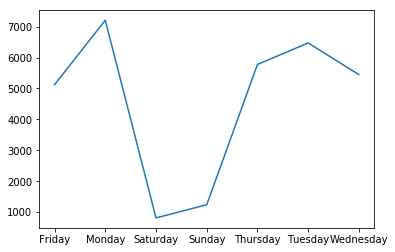

In [41]:
plt.plot(cohort_24.groupby(cohort_24.day_of_week)['date'].count())

In [42]:
cohort_24_over_130 = cohort_24[cohort_24.running_days > 130]
cohort_24_over_130.shape

(1738, 9)

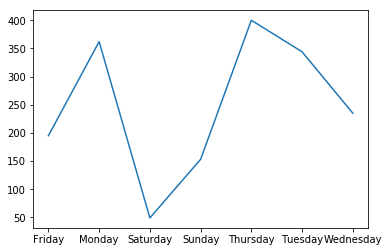

In [43]:
plt.plot(cohort_24_over_130.groupby(cohort_24_over_130.day_of_week)['date'].count())

In [44]:
cohort_24.groupby(cohort_24.user)['date'].count()

user
182     856
183    1674
184    1023
185    1111
186    2002
187    1297
188    1482
189    1510
190    1747
191    1239
192    1546
193    1025
194     927
195    1714
196    1153
197    1894
198     705
199    1408
200     760
201     755
202     365
203    1083
204    1351
205     886
206     469
207     969
208    1124
Name: date, dtype: int64

In [45]:
cohort_24_under_130 = cohort_24[cohort_24.running_days <= 130]
cohort_24_under_130.shape

(30337, 9)

In [46]:
cohort_24_under_130.sample(10)

,date,time,stuff,program,user,cohort,ip,running_days,day_of_week
timestamp,,,,,,,,,
2018-08-27 14:45:08,2018-08-27,2019-05-01 14:45:08,java-iii/sessions-and-cookies 207 24 97.105.19.58,java-iii/sessions-and-cookies,207,24,97.105.19.58,90,Monday
2018-08-10 08:14:59,2018-08-10,2019-05-01 08:14:59,mysql/users 187 24 97.105.19.58,mysql/users,187,24,97.105.19.58,73,Friday
2018-07-23 11:10:13,2018-07-23,2019-05-01 11:10:13,java-i 208 24 97.105.19.58,java-i,208,24,97.105.19.58,55,Monday
2018-07-10 15:30:15,2018-07-10,2019-05-01 15:30:15,javascript-i/bom-and-dom/dom-events 204 24 97....,javascript-i/bom-and-dom/dom-events,204,24,97.105.19.61,42,Tuesday
2018-06-06 10:55:24,2018-06-06,2019-05-01 10:55:24,html-css/css-ii/bootstrap-introduction 190 24 ...,html-css/css-ii/bootstrap-introduction,190,24,97.105.19.61,8,Wednesday
2018-06-22 14:48:48,2018-06-22,2019-05-01 14:48:48,html-css/introduction 205 24 97.105.19.61,html-css/introduction,205,24,97.105.19.61,24,Friday
2018-08-07 09:12:22,2018-08-07,2019-05-01 09:12:22,java-ii 194 24 97.105.19.58,java-ii,194,24,97.105.19.58,70,Tuesday
2018-08-09 08:55:48,2018-08-09,2019-05-01 08:55:48,java-ii 208 24 97.105.19.58,java-ii,208,24,97.105.19.58,72,Thursday
2018-07-12 09:55:34,2018-07-12,2019-05-01 09:55:34,javascript-i/bom-and-dom/bom 188 24 97.105.19.61,javascript-i/bom-and-dom/bom,188,24,97.105.19.61,44,Thursday


In [47]:
cohort_24_under_130.groupby(cohort_24_under_130.user)['date'].count()

user
182     856
183    1618
184    1006
185    1046
186    1459
187    1204
188    1306
189    1203
190    1724
191    1239
192    1546
193    1002
194     927
195    1596
196    1153
197    1785
198     615
199    1408
200     756
201     687
202     365
203    1083
204    1321
205     886
206     463
207     969
208    1114
Name: date, dtype: int64

In [48]:
cohort_24_over_130.groupby(cohort_24_over_130.user)['date'].count()

user
183     56
184     17
185     65
186    543
187     93
188    176
189    307
190     23
193     23
195    118
197    109
198     90
200      4
201     68
204     30
206      6
208     10
Name: date, dtype: int64

In [49]:
cohort_24_user_grouped = pd.DataFrame(cohort_24_under_130.user.value_counts()).reset_index().\
    rename(index=str, columns={'index':'user', 'user':'count'})
cohort_24_user_grouped

,user,count
0,197,1785
1,190,1724
2,183,1618
3,195,1596
4,192,1546
5,186,1459
6,199,1408
7,204,1321
8,188,1306
9,191,1239


In [50]:
cohort_24_under_130.dtypes

date            datetime64[ns]
time            datetime64[ns]
stuff                   object
program                 object
user                     int64
cohort                   int64
ip                      object
running_days             int64
day_of_week             object
dtype: object

In [51]:
cohort_24_under_130.dropna(inplace=True)

In [52]:
cohort_24_under_130.user.count()

30337

In [53]:
cohort_24_grouped_proba = pd.DataFrame(cohort_24_under_130.user.value_counts()/cohort_24_under_130.user.count()).reset_index().rename(index=str, columns={'index':'user', 'user':'proba_during'})
cohort_24_grouped_proba

,user,proba_during
0,197,0.058839
1,190,0.056828
2,183,0.053334
3,195,0.052609
4,192,0.050961
5,186,0.048093
6,199,0.046412
7,204,0.043544
8,188,0.043050
9,191,0.040841


In [54]:
cohort_24_grouped_proba_after = pd.DataFrame(cohort_24_over_130.user.value_counts()/cohort_24_over_130.user.count()).reset_index().rename(index=str, columns={'index':'user', 'user':'proba_after'})
cohort_24_grouped_proba_after

,user,proba_after
0,186,0.312428
1,189,0.176640
2,188,0.101266
3,195,0.067894
4,197,0.062716
5,187,0.053510
6,198,0.051784
7,201,0.039125
8,185,0.037399
9,183,0.032221


In [55]:
cohort_24_over_130.user.value_counts()

186    543
189    307
188    176
195    118
197    109
187     93
198     90
201     68
185     65
183     56
204     30
193     23
190     23
184     17
208     10
206      6
200      4
Name: user, dtype: int64

In [56]:
cohort_24_under_130.user.value_counts()

197    1785
190    1724
183    1618
195    1596
192    1546
186    1459
199    1408
204    1321
188    1306
191    1239
187    1204
189    1203
196    1153
208    1114
203    1083
185    1046
184    1006
193    1002
207     969
194     927
205     886
182     856
200     756
201     687
198     615
206     463
202     365
Name: user, dtype: int64

In [57]:
cohort_24_grouped_proba_after_overall = pd.DataFrame(cohort_24_over_130.user.value_counts()/(cohort_24_over_130.user.value_counts()+cohort_24_under_130.user.value_counts())).reset_index().rename(index=str, columns={'index':'user', 'user':'percent_after'})
cohort_24_grouped_proba_after_overall 

,user,percent_after
0,182,NaN
1,183,0.033453
2,184,0.016618
3,185,0.058506
4,186,0.271229
5,187,0.071704
6,188,0.118758
7,189,0.203311
8,190,0.013165
9,191,NaN


In [58]:
cohort_24_proba = cohort_24_grouped_proba.merge(cohort_24_grouped_proba_after, 'left', on='user')
cohort_24_proba

,user,proba_during,proba_after
0,197,0.058839,0.062716
1,190,0.056828,0.013234
2,183,0.053334,0.032221
3,195,0.052609,0.067894
4,192,0.050961,NaN
5,186,0.048093,0.312428
6,199,0.046412,NaN
7,204,0.043544,0.017261
8,188,0.043050,0.101266
9,191,0.040841,NaN


In [59]:
cohort_24_proba = cohort_24_proba.merge(cohort_24_grouped_proba_after_overall, 'left', on='user')
cohort_24_proba

,user,proba_during,proba_after,percent_after
0,197,0.058839,0.062716,0.057550
1,190,0.056828,0.013234,0.013165
2,183,0.053334,0.032221,0.033453
3,195,0.052609,0.067894,0.068845
4,192,0.050961,NaN,NaN
5,186,0.048093,0.312428,0.271229
6,199,0.046412,NaN,NaN
7,204,0.043544,0.017261,0.022206
8,188,0.043050,0.101266,0.118758
9,191,0.040841,NaN,NaN


In [60]:
cohort_24_proba.fillna(0)

,user,proba_during,proba_after,percent_after
0,197,0.058839,0.062716,0.057550
1,190,0.056828,0.013234,0.013165
2,183,0.053334,0.032221,0.033453
3,195,0.052609,0.067894,0.068845
4,192,0.050961,0.000000,0.000000
5,186,0.048093,0.312428,0.271229
6,199,0.046412,0.000000,0.000000
7,204,0.043544,0.017261,0.022206
8,188,0.043050,0.101266,0.118758
9,191,0.040841,0.000000,0.000000


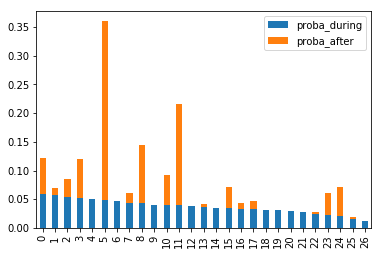

In [61]:
cohort_24_proba[['proba_during', 'proba_after']].plot(kind='bar', stacked=True)


In [62]:
df[df.user == '186']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 186 24 97.105.19.61,/,186,24,97.105.19.61
2018-05-29 14:43:22,2018-05-29,2019-05-01 14:43:22,html-css 186 24 97.105.19.61,html-css,186,24,97.105.19.61
2018-05-30 10:50:46,2018-05-30,2019-05-01 10:50:46,appendix 186 24 97.105.19.61,appendix,186,24,97.105.19.61
2018-05-30 10:50:52,2018-05-30,2019-05-01 10:50:52,appendix/git/intellij-intro 186 24 97.105.19.61,appendix/git/intellij-intro,186,24,97.105.19.61
2018-05-30 11:47:27,2018-05-30,2019-05-01 11:47:27,html-css 186 24 97.105.19.61,html-css,186,24,97.105.19.61
2018-05-30 11:48:28,2018-05-30,2019-05-01 11:48:28,appendix 186 24 97.105.19.61,appendix,186,24,97.105.19.61
2018-05-30 11:48:32,2018-05-30,2019-05-01 11:48:32,appendix/git/intellij 186 24 97.105.19.61,appendix/git/intellij,186,24,97.105.19.61
2018-05-30 12:58:59,2018-05-30,2019-05-01 12:58:59,appendix/git/cli 186 24 97.105.19.61,appendix/git/cli,186,24,97.105.19.61
2018-05-30 13:35:37,2018-05-30,2019-05-01 13:35:37,html-css 186 24 97.105.19.61,html-css,186,24,97.105.19.61


In [63]:
df[df.user == '189']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-05-29 14:42:45,2018-05-29,2019-05-01 14:42:45,/ 189 24 97.105.19.61,/,189,24,97.105.19.61
2018-05-30 09:06:42,2018-05-30,2019-05-01 09:06:42,html-css 189 24 97.105.19.61,html-css,189,24,97.105.19.61
2018-05-30 09:06:48,2018-05-30,2019-05-01 09:06:48,html-css/introduction 189 24 97.105.19.61,html-css/introduction,189,24,97.105.19.61
2018-05-30 09:06:55,2018-05-30,2019-05-01 09:06:55,html-css 189 24 97.105.19.61,html-css,189,24,97.105.19.61
2018-05-30 09:07:36,2018-05-30,2019-05-01 09:07:36,html-css/introduction 189 24 97.105.19.61,html-css/introduction,189,24,97.105.19.61
2018-05-30 10:50:46,2018-05-30,2019-05-01 10:50:46,appendix 189 24 97.105.19.61,appendix,189,24,97.105.19.61
2018-05-30 10:50:50,2018-05-30,2019-05-01 10:50:50,appendix/git/intellij-intro 189 24 97.105.19.61,appendix/git/intellij-intro,189,24,97.105.19.61
2018-05-30 13:35:26,2018-05-30,2019-05-01 13:35:26,html-css 189 24 97.105.19.61,html-css,189,24,97.105.19.61
2018-05-30 13:37:46,2018-05-30,2019-05-01 13:37:46,html-css/introduction 189 24 97.105.19.61,html-css/introduction,189,24,97.105.19.61


In [64]:
df[df.user == '188']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-05-29 14:42:44,2018-05-29,2019-05-01 14:42:44,/ 188 24 97.105.19.61,/,188,24,97.105.19.61
2018-05-30 10:50:58,2018-05-30,2019-05-01 10:50:58,/ 188 24 97.105.19.61,/,188,24,97.105.19.61
2018-05-30 10:51:11,2018-05-30,2019-05-01 10:51:11,html-css/introduction 188 24 97.105.19.61,html-css/introduction,188,24,97.105.19.61
2018-05-30 11:46:10,2018-05-30,2019-05-01 11:46:10,appendix/git/intellij-intro 188 24 97.105.19.61,appendix/git/intellij-intro,188,24,97.105.19.61
2018-05-30 11:47:06,2018-05-30,2019-05-01 11:47:06,appendix/git/intellij 188 24 97.105.19.61,appendix/git/intellij,188,24,97.105.19.61
2018-05-30 13:38:15,2018-05-30,2019-05-01 13:38:15,/ 188 24 97.105.19.61,/,188,24,97.105.19.61
2018-05-30 13:38:21,2018-05-30,2019-05-01 13:38:21,html-css/introduction 188 24 97.105.19.61,html-css/introduction,188,24,97.105.19.61
2018-05-30 13:44:11,2018-05-30,2019-05-01 13:44:11,appendix/git/intellij 188 24 97.105.19.61,appendix/git/intellij,188,24,97.105.19.61
2018-05-30 15:16:35,2018-05-30,2019-05-01 15:16:35,html-css/elements 188 24 97.105.19.61,html-css/elements,188,24,97.105.19.61


In [65]:
cohort_24[cohort_24.ip == '170.248.173.246']['user'].unique()

array([201, 186, 189, 188, 197])

# Time Series Anomaly

In [66]:
cohort_24.dtypes

date            datetime64[ns]
time            datetime64[ns]
stuff                   object
program                 object
user                     int64
cohort                   int64
ip                      object
running_days             int64
day_of_week             object
dtype: object

In [67]:
cohort_24.head()

,date,time,stuff,program,user,cohort,ip,running_days,day_of_week
timestamp,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-01 14:42:38,/ 182 24 97.105.19.61,/,182,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:39,2018-05-29,2019-05-01 14:42:39,/ 183 24 97.105.19.61,/,183,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 184 24 97.105.19.61,/,184,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 185 24 97.105.19.61,/,185,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 186 24 97.105.19.61,/,186,24,97.105.19.61,0,Tuesday


In [68]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')
df_ts_size = cohort_24['date'].resample('W').count()
idx = pd.date_range(
    df_ts_size.sort_index().index.min(),
    df_ts_size.sort_index().index.max(),
    freq='W'
)
df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [69]:
short_rolling = df_ts_size.rolling(window=3).mean()
long_rolling = df_ts_size.rolling(window=6).mean()

Text(0, 0.5, 'Count')

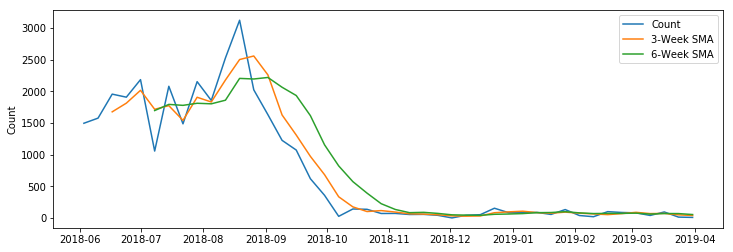

In [70]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_size.index, 
        df_ts_size,
        label='Count')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '3-Week SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '6-Week SMA')

ax.legend(loc='best')
ax.set_ylabel('Count')

## It looks like there were a lot of visits to the curriculum right when capstone projects were started.

In [71]:
ema_short = df_ts_size.ewm(span=3, adjust=False).mean()
ema_short[0:3]

2018-06-03    1495.00
2018-06-10    1535.50
2018-06-17    1745.25
Freq: W-SUN, Name: date, dtype: float64

In [72]:
ema_long = df_ts_size.ewm(span=6, adjust=False).mean()
ema_long[0:3]

2018-06-03    1495.000000
2018-06-10    1518.142857
2018-06-17    1642.959184
Freq: W-SUN, Name: date, dtype: float64

In [73]:
span = 6
ema_long = df_ts_size.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-6:-1].std()*3
lb = midband - ema_long[-6:-1].std()*3

Text(0, 0.5, 'Count')

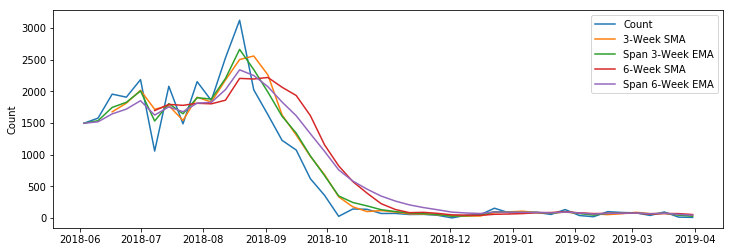

In [74]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_size.index, 
        df_ts_size,
        label='Count')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '3-Week SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 3-Week EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '6-Week SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 6-Week EMA')

ax.legend(loc='best')
ax.set_ylabel('Count')

# yhat = pd.DataFrame(dict(actual=test))

In [75]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')
df_user_count = cohort_24['user'].resample('M').mean()
idx = pd.date_range(
    df_user_count.sort_index().index.min(),
    df_user_count.sort_index().index.max(),
    freq='M'
)
df_user_count = df_user_count.reindex(idx, fill_value=0).fillna(value=0)

In [76]:
short_rolling = df_user_count.rolling(window=2).mean()
long_rolling = df_user_count.rolling(window=4).mean()

Text(0, 0.5, 'Count')

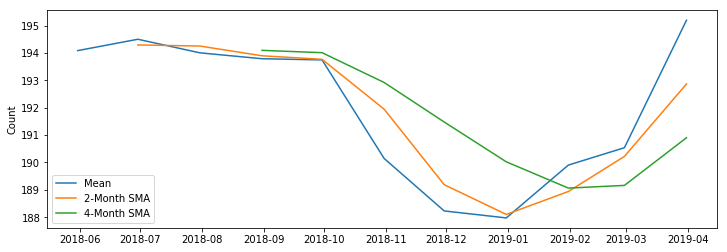

In [77]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_user_count.index, 
        df_user_count,
        label='Mean')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '2-Month SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '4-Month SMA')

ax.legend(loc='best')
ax.set_ylabel('Count')

In [78]:
cohort_24.head()

,date,time,stuff,program,user,cohort,ip,running_days,day_of_week
timestamp,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-01 14:42:38,/ 182 24 97.105.19.61,/,182,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:39,2018-05-29,2019-05-01 14:42:39,/ 183 24 97.105.19.61,/,183,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 184 24 97.105.19.61,/,184,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 185 24 97.105.19.61,/,185,24,97.105.19.61,0,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-01 14:42:42,/ 186 24 97.105.19.61,/,186,24,97.105.19.61,0,Tuesday


In [79]:
cohort_24['user_id'] = cohort_24['user']

In [80]:
df_agg = cohort_24.groupby(['date','user'])['user_id'].count().reset_index().rename(index=str, columns={'user_id':'num_view'})

In [81]:
df_agg[df_agg.user == 182].head(10)

,date,user,num_view
0,2018-05-29,182,10
26,2018-05-30,182,5
53,2018-05-31,182,11
80,2018-06-01,182,10
123,2018-06-04,182,14
150,2018-06-05,182,1
177,2018-06-06,182,4
204,2018-06-07,182,4
272,2018-06-11,182,15
298,2018-06-12,182,8


In [82]:
cohort_24[cohort_24.user == 182]

,date,time,stuff,program,user,cohort,ip,running_days,day_of_week,user_id
timestamp,,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-01 14:42:38,/ 182 24 97.105.19.61,/,182,24,97.105.19.61,0,Tuesday,182
2018-05-29 21:19:51,2018-05-29,2019-05-01 21:19:51,prework/cli 182 24 67.11.172.66,prework/cli,182,24,67.11.172.66,0,Tuesday,182
2018-05-29 21:19:56,2018-05-29,2019-05-01 21:19:56,prework/cli/01-intro 182 24 67.11.172.66,prework/cli/01-intro,182,24,67.11.172.66,0,Tuesday,182
2018-05-29 21:20:51,2018-05-29,2019-05-01 21:20:51,prework/cli/02-listing-files 182 24 67.11.172.66,prework/cli/02-listing-files,182,24,67.11.172.66,0,Tuesday,182
2018-05-29 21:22:15,2018-05-29,2019-05-01 21:22:15,prework/cli/03-file-paths 182 24 67.11.172.66,prework/cli/03-file-paths,182,24,67.11.172.66,0,Tuesday,182
2018-05-29 21:23:38,2018-05-29,2019-05-01 21:23:38,prework/cli/04-navigating-the-filesystem 182 2...,prework/cli/04-navigating-the-filesystem,182,24,67.11.172.66,0,Tuesday,182
2018-05-29 21:23:49,2018-05-29,2019-05-01 21:23:49,prework/cli/05-creating-files-and-directories ...,prework/cli/05-creating-files-and-directories,182,24,67.11.172.66,0,Tuesday,182
2018-05-29 21:24:57,2018-05-29,2019-05-01 21:24:57,prework/cli/06-moving-files 182 24 67.11.172.66,prework/cli/06-moving-files,182,24,67.11.172.66,0,Tuesday,182
2018-05-29 21:25:16,2018-05-29,2019-05-01 21:25:16,appendix/further-reading/javascript/hoisting 1...,appendix/further-reading/javascript/hoisting,182,24,67.11.172.66,0,Tuesday,182


In [83]:
df_agg = df_agg.set_index('date').rename(index=str, columns={'num_view':'ema'})
df_agg.head()

,user,ema
date,,
2018-05-29 00:00:00,182,10
2018-05-29 00:00:00,183,1
2018-05-29 00:00:00,184,2
2018-05-29 00:00:00,185,5
2018-05-29 00:00:00,186,2


In [84]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [85]:
# bands = []
# for user in users:
#     bb = bollinger_bands(df.user)
#     bands.append(bb)
    
# df2 = pd.concat(bands)

In [86]:
instructors = df[df.cohort == '28']
instructors.user.value_counts()

11     1525
1      1022
64     1000
314     704
248     600
211     563
53      321
312     131
146     100
397      74
40       66
370      54
4         1
Name: user, dtype: int64

In [87]:
int_id = list(instructors.user.unique())
int_id = sorted(int_id)
int_id

['1',
 '11',
 '146',
 '211',
 '248',
 '312',
 '314',
 '370',
 '397',
 '4',
 '40',
 '53',
 '64']

In [88]:
instructors.head(20)

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-12-06 14:15:29,2018-12-06,2019-05-01 14:15:29,appendix/further-reading/java/intellij-tomcat-...,appendix/further-reading/java/intellij-tomcat-...,53,28,97.105.
2018-12-06 14:25:40,2018-12-06,2019-05-01 14:25:40,javascript-i 314 28 97.105.19.58,javascript-i,314,28,97.105.19.58
2018-12-06 14:25:41,2018-12-06,2019-05-01 14:25:41,javascript-i/coffee-project 314 28 97.105.19.58,javascript-i/coffee-project,314,28,97.105.19.58
2018-12-06 15:31:29,2018-12-06,2019-05-01 15:31:29,spring 40 28 170.248.173.247,spring,40,28,170.248.173.247
2018-12-06 15:31:33,2018-12-06,2019-05-01 15:31:33,spring/fundamentals/security 40 28 170.248.173...,spring/fundamentals/security,40,28,170.248.173.247
2018-12-06 15:33:32,2018-12-06,2019-05-01 15:33:32,appendix/further-reading/spring/authorization ...,appendix/further-reading/spring/authorization,40,28,170.248.173.247
2018-12-06 15:34:29,2018-12-06,2019-05-01 15:34:29,spring/fundamentals/security/authentication 40...,spring/fundamentals/security/authentication,40,28,170.248.173.247
2018-12-06 15:38:58,2018-12-06,2019-05-01 15:38:58,appendix/further-reading/spring/authorization ...,appendix/further-reading/spring/authorization,40,28,170.248.173.247
2018-12-06 15:39:55,2018-12-06,2019-05-01 15:39:55,appendix/further-reading/spring/security-use-c...,appendix/further-reading/spring/security-use-c...,40,28,170.248.173.247


In [89]:
instructors[instructors.program == '6.6.1_Logistic_Regression']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2019-03-27 08:44:33,2019-03-27,2019-05-01 08:44:33,6.6.1_Logistic_Regression 248 28 97.105.19.58,6.6.1_Logistic_Regression,248,28,97.105.19.58
2019-03-29 13:21:41,2019-03-29,2019-05-01 13:21:41,6.6.1_Logistic_Regression 397 28 108.84.76.42,6.6.1_Logistic_Regression,397,28,108.84.76.42
2019-03-31 19:42:41,2019-03-31,2019-05-01 19:42:41,6.6.1_Logistic_Regression 1 28 70.121.210.246,6.6.1_Logistic_Regression,1,28,70.121.210.246
2019-04-01 07:44:55,2019-04-01,2019-05-01 07:44:55,6.6.1_Logistic_Regression 1 28 97.105.19.58,6.6.1_Logistic_Regression,1,28,97.105.19.58
2019-04-01 11:22:37,2019-04-01,2019-05-01 11:22:37,6.6.1_Logistic_Regression 248 28 97.105.19.58,6.6.1_Logistic_Regression,248,28,97.105.19.58


In [90]:
ada_class = df[(df.program == '6.6.1_Logistic_Regression') & (df.cohort == '')]
ada = list(ada_class.user.unique())
ada = sorted(ada)
ada

['349',
 '351',
 '352',
 '353',
 '354',
 '355',
 '357',
 '359',
 '361',
 '362',
 '363',
 '364',
 '366',
 '367',
 '368',
 '369',
 '372']

In [91]:
ada_class.sample(20)

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2019-04-01 11:22:55,2019-04-01,2019-05-01 11:22:55,6.6.1_Logistic_Regression 372 97.105.19.58,6.6.1_Logistic_Regression,372,,97.105.19.58
2019-03-29 13:23:52,2019-03-29,2019-05-01 13:23:52,6.6.1_Logistic_Regression 355 97.105.19.58,6.6.1_Logistic_Regression,355,,97.105.19.58
2019-04-01 15:17:12,2019-04-01,2019-05-01 15:17:12,6.6.1_Logistic_Regression 351 97.105.19.58,6.6.1_Logistic_Regression,351,,97.105.19.58
2019-03-31 20:37:40,2019-03-31,2019-05-01 20:37:40,6.6.1_Logistic_Regression 353 24.26.242.9,6.6.1_Logistic_Regression,353,,24.26.242.9
2019-04-01 09:46:26,2019-04-01,2019-05-01 09:46:26,6.6.1_Logistic_Regression 361 97.105.19.58,6.6.1_Logistic_Regression,361,,97.105.19.58
2019-03-28 16:56:42,2019-03-28,2019-05-01 16:56:42,6.6.1_Logistic_Regression 363 97.105.19.58,6.6.1_Logistic_Regression,363,,97.105.19.58
2019-04-01 09:58:17,2019-04-01,2019-05-01 09:58:17,6.6.1_Logistic_Regression 355 97.105.19.58,6.6.1_Logistic_Regression,355,,97.105.19.58
2019-04-01 10:05:26,2019-04-01,2019-05-01 10:05:26,6.6.1_Logistic_Regression 361 97.105.19.58,6.6.1_Logistic_Regression,361,,97.105.19.58
2019-04-01 11:01:53,2019-04-01,2019-05-01 11:01:53,6.6.1_Logistic_Regression 353 97.105.19.58,6.6.1_Logistic_Regression,353,,97.105.19.58


In [92]:
df[df.cohort == '']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-01-26 16:46:16,2018-01-26,2019-05-01 16:46:16,/ 48 97.105.19.61,/,48,,97.105.19.61
2018-01-26 16:46:24,2018-01-26,2019-05-01 16:46:24,spring/extra-features/form-validation 48 97.1...,spring/extra-features/form-validation,48,,97.105.19.61
2018-01-26 17:54:24,2018-01-26,2019-05-01 17:54:24,/ 48 97.105.19.61,/,48,,97.105.19.61
2018-01-26 18:32:03,2018-01-26,2019-05-01 18:32:03,/ 48 97.105.19.61,/,48,,97.105.19.61
2018-01-26 18:32:17,2018-01-26,2019-05-01 18:32:17,mysql/relationships/joins 48 97.105.19.61,mysql/relationships/joins,48,,97.105.19.61
2018-01-26 18:32:33,2018-01-26,2019-05-01 18:32:33,mysql/tables 48 97.105.19.61,mysql/tables,48,,97.105.19.61
2018-01-26 18:32:37,2018-01-26,2019-05-01 18:32:37,mysql/databases 48 97.105.19.61,mysql/databases,48,,97.105.19.61
2018-01-26 18:32:43,2018-01-26,2019-05-01 18:32:43,mysql/relationships 48 97.105.19.61,mysql/relationships,48,,97.105.19.61
2018-01-26 18:32:47,2018-01-26,2019-05-01 18:32:47,mysql/relationships/joins 48 97.105.19.61,mysql/relationships/joins,48,,97.105.19.61


In [93]:
# Zach
df[df.user == '1']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 10:40:15,2018-01-26,2019-05-01 10:40:15,javascript-i/functions 1 8 97.105.19.61,javascript-i/functions,1,8,97.105.19.61
2018-01-26 11:26:13,2018-01-26,2019-05-01 11:26:13,java-i 1 8 97.105.19.61,java-i,1,8,97.105.19.61
2018-01-26 11:43:17,2018-01-26,2019-05-01 11:43:17,mkdocs/search_index.json 1 8 97.105.19.61,mkdocs/search_index.json,1,8,97.105.19.61
2018-01-27 07:49:25,2018-01-27,2019-05-01 07:49:25,teams/13 1 8 72.177.226.58,teams/13,1,8,72.177.226.58
2018-01-28 16:32:37,2018-01-28,2019-05-01 16:32:37,content/php_i/types-and-variables-ii/objects-o...,content/php_i/types-and-variables-ii/objects-o...,1,13,72.179.161.39
2018-01-29 11:41:51,2018-01-29,2019-05-01 11:41:51,javascript-i/conditionals 1 8 97.105.19.61,javascript-i/conditionals,1,8,97.105.19.61


In [94]:
# Dimitri..No
df[df.user == '146']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-03-19 08:35:51,2018-03-19,2019-05-01 08:35:51,/ 146 1 97.105.19.61,/,146,1,97.105.19.61
2018-03-19 08:37:27,2018-03-19,2019-05-01 08:37:27,content/html-css 146 1 97.105.19.61,content/html-css,146,1,97.105.19.61
2018-03-19 08:37:27,2018-03-19,2019-05-01 08:37:27,content/html-css/gitbook/images/favicon.ico 14...,content/html-css/gitbook/images/favicon.ico,146,1,97.105.19.61
2018-03-19 08:37:30,2018-03-19,2019-05-01 08:37:30,content/html-css 146 1 97.105.19.61,content/html-css,146,1,97.105.19.61
2018-03-19 08:37:35,2018-03-19,2019-05-01 08:37:35,content/html-css/introduction.html 146 1 97.10...,content/html-css/introduction.html,146,1,97.105.19.61
2018-03-19 08:38:04,2018-03-19,2019-05-01 08:38:04,content/html-css/elements.html 146 1 97.105.19.61,content/html-css/elements.html,146,1,97.105.19.61
2018-03-19 08:38:04,2018-03-19,2019-05-01 08:38:04,content/html-css/forms.html 146 1 97.105.19.61,content/html-css/forms.html,146,1,97.105.19.61
2018-03-19 08:38:05,2018-03-19,2019-05-01 08:38:05,content/html-css/css-i 146 1 97.105.19.61,content/html-css/css-i,146,1,97.105.19.61
2018-03-19 08:38:05,2018-03-19,2019-05-01 08:38:05,content/html-css/css-i/gitbook/images/favicon....,content/html-css/css-i/gitbook/images/favicon.ico,146,1,97.105.19.61


In [95]:
# Maggie
df[df.user == '248']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-09-05 14:28:23,2018-09-05,2019-05-01 14:28:23,/ 248 1 97.105.19.58,/,248,1,97.105.19.58
2018-09-07 14:53:23,2018-09-07,2019-05-01 14:53:23,/ 248 1 97.105.19.58,/,248,1,97.105.19.58
2018-09-07 14:54:13,2018-09-07,2019-05-01 14:54:13,html-css 248 1 97.105.19.58,html-css,248,1,97.105.19.58
2018-09-07 14:56:07,2018-09-07,2019-05-01 14:56:07,html-css/introduction 248 1 97.105.19.58,html-css/introduction,248,1,97.105.19.58
2018-09-07 14:57:00,2018-09-07,2019-05-01 14:57:00,html-css/elements 248 1 97.105.19.58,html-css/elements,248,1,97.105.19.58
2018-09-07 14:57:42,2018-09-07,2019-05-01 14:57:42,html-css/forms 248 1 97.105.19.58,html-css/forms,248,1,97.105.19.58
2018-09-07 14:58:10,2018-09-07,2019-05-01 14:58:10,html-css/css-i 248 1 97.105.19.58,html-css/css-i,248,1,97.105.19.58
2018-09-07 14:58:16,2018-09-07,2019-05-01 14:58:16,html-css/css-i/introduction 248 1 97.105.19.58,html-css/css-i/introduction,248,1,97.105.19.58
2018-09-07 14:58:19,2018-09-07,2019-05-01 14:58:19,html-css/css-i/selectors-and-properties 248 1 ...,html-css/css-i/selectors-and-properties,248,1,97.105.19.58


In [96]:
# Mark
df[df.user == '397']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2019-03-29 13:02:00,2019-03-29,2019-05-01 13:02:00,/ 397 28 108.84.76.42,/,397,28,108.84.76.42
2019-03-29 13:02:08,2019-03-29,2019-05-01 13:02:08,1._Fundamentals 397 28 108.84.76.42,1._Fundamentals,397,28,108.84.76.42
2019-03-29 13:02:47,2019-03-29,2019-05-01 13:02:47,Pipeline_Demo 397 28 108.84.76.42,Pipeline_Demo,397,28,108.84.76.42
2019-03-29 13:03:57,2019-03-29,2019-05-01 13:03:57,1._Fundamentals 397 28 108.84.76.42,1._Fundamentals,397,28,108.84.76.42
2019-03-29 13:04:16,2019-03-29,2019-05-01 13:04:16,4.0_overview 397 28 108.84.76.42,4.0_overview,397,28,108.84.76.42
2019-03-29 13:04:38,2019-03-29,2019-05-01 13:04:38,4.1_introduction 397 28 108.84.76.42,4.1_introduction,397,28,108.84.76.42
2019-03-29 13:10:58,2019-03-29,2019-05-01 13:10:58,4.2_data_types_and_variables 397 28 108.84.76.42,4.2_data_types_and_variables,397,28,108.84.76.42
2019-03-29 13:14:23,2019-03-29,2019-05-01 13:14:23,6.1_Overview 397 28 108.84.76.42,6.1_Overview,397,28,108.84.76.42
2019-03-29 13:15:11,2019-03-29,2019-05-01 13:15:11,6.2_About 397 28 108.84.76.42,6.2_About,397,28,108.84.76.42


In [115]:
df[df.user == '349']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2019-02-04 16:22:20,2019-02-04,2019-05-01 16:22:20,/ 349 97.105.19.58,/,349,,97.105.19.58
2019-02-04 16:56:21,2019-02-04,2019-05-01 16:56:21,/ 349 97.105.19.58,/,349,,97.105.19.58
2019-02-05 00:14:44,2019-02-05,2019-05-01 00:14:44,/ 349 24.160.139.8,/,349,,24.160.139.8
2019-02-05 00:14:47,2019-02-05,2019-05-01 00:14:47,1._Fundamentals 349 24.160.139.8,1._Fundamentals,349,,24.160.139.8
2019-02-05 09:00:11,2019-02-05,2019-05-01 09:00:11,/ 349 97.105.19.58,/,349,,97.105.19.58
2019-02-05 09:00:24,2019-02-05,2019-05-01 09:00:24,1._Fundamentals 349 97.105.19.58,1._Fundamentals,349,,97.105.19.58
2019-02-05 09:02:01,2019-02-05,2019-05-01 09:02:01,1._Fundamentals 349 97.105.19.58,1._Fundamentals,349,,97.105.19.58
2019-02-06 08:38:33,2019-02-06,2019-05-01 08:38:33,/ 349 97.105.19.58,/,349,,97.105.19.58
2019-02-06 08:39:03,2019-02-06,2019-05-01 08:39:03,1._Fundamentals 349 97.105.19.58,1._Fundamentals,349,,97.105.19.58


In [139]:
df.head()

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,2018-01-26,2019-05-01 09:56:24,javascript-i/conditionals 2 22 97.105.19.61,javascript-i/conditionals,2,22,97.105.19.61
2018-01-26 09:56:41,2018-01-26,2019-05-01 09:56:41,javascript-i/loops 2 22 97.105.19.61,javascript-i/loops,2,22,97.105.19.61


In [140]:
df.tail()

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2019-04-02 11:10:19,2019-04-02,2019-05-01 11:10:19,java-ii/annotations 329 29 97.105.19.58,java-ii/annotations,329,29,97.105.19.58
2019-04-02 11:11:18,2019-04-02,2019-05-01 11:11:18,javascript-i/introduction/working-with-data-ty...,javascript-i/introduction/working-with-data-ty...,384,31,97.105.19.5
2019-04-02 11:11:23,2019-04-02,2019-05-01 11:11:23,javascript-i 373 31 97.105.19.58,javascript-i,373,31,97.105.19.58
2019-04-02 11:11:25,2019-04-02,2019-05-01 11:11:25,javascript-i/introduction/working-with-data-ty...,javascript-i/introduction/working-with-data-ty...,376,31,97.105.19.5
2019-04-02 11:11:29,2019-04-02,2019-05-01 11:11:29,javascript-i/introduction/working-with-data-ty...,javascript-i/introduction/working-with-data-ty...,373,31,97.105.19.5


In [142]:
df[((df.index < '2018-02-10') & (df.ip == '97.105.19.61')) & ((df.index > '2019-02-10') & (df.ip == '97.105.19.58'))]

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,


In [175]:
old = pd.DataFrame(df.user[(df.index < '2018-02-10') & (df.ip == '97.105.19.61')].unique())
old.rename(index=str, columns={0:'user'}, inplace=True)
old.head()

,user
0,1
1,2
2,3
3,4
4,5


In [176]:
new = pd.DataFrame(df.user[(df.index > '2019-02-10') & (df.ip == '97.105.19.58')].unique())
new.rename(index=str, columns={0:'user'}, inplace=True)
new.head()

,user
0,339
1,211
2,337
3,353
4,333


In [177]:
old_and_new = old.merge(new, how='inner', on='user')
old_and_new

,user
0,1
1,11
2,41
3,53
4,64


### Above, we see users that have accessed curriculum from Codeup IP addresses both at the beginning of the log data and at the end, indicating that these users are most likely instructors/employees.  From there, we could find similiarities to find other instructors/employees.

In [206]:
df[df.user=='1']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-01-26 09:56:02,2018-01-26,2019-05-01 09:56:02,java-ii 1 8 97.105.19.61,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,2018-01-26,2019-05-01 09:56:05,java-ii/object-oriented-programming 1 8 97.105...,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,2018-01-26,2019-05-01 09:56:06,slides/object_oriented_programming 1 8 97.105....,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 10:40:15,2018-01-26,2019-05-01 10:40:15,javascript-i/functions 1 8 97.105.19.61,javascript-i/functions,1,8,97.105.19.61
2018-01-26 11:26:13,2018-01-26,2019-05-01 11:26:13,java-i 1 8 97.105.19.61,java-i,1,8,97.105.19.61
2018-01-26 11:43:17,2018-01-26,2019-05-01 11:43:17,mkdocs/search_index.json 1 8 97.105.19.61,mkdocs/search_index.json,1,8,97.105.19.61
2018-01-27 07:49:25,2018-01-27,2019-05-01 07:49:25,teams/13 1 8 72.177.226.58,teams/13,1,8,72.177.226.58
2018-01-28 16:32:37,2018-01-28,2019-05-01 16:32:37,content/php_i/types-and-variables-ii/objects-o...,content/php_i/types-and-variables-ii/objects-o...,1,13,72.179.161.39
2018-01-29 11:41:51,2018-01-29,2019-05-01 11:41:51,javascript-i/conditionals 1 8 97.105.19.61,javascript-i/conditionals,1,8,97.105.19.61


### User 1 has Cohort 8 to begin and then ends in Cohort 28.

In [179]:
df[df.user=='11']

,date,time,stuff,program,user,cohort,ip
timestamp,,,,,,,
2018-01-26 10:14:47,2018-01-26,2019-05-01 10:14:47,/ 11 1 97.105.19.61,/,11,1,97.105.19.61
2018-01-26 10:14:51,2018-01-26,2019-05-01 10:14:51,javascript-i 11 1 97.105.19.61,javascript-i,11,1,97.105.19.61
2018-01-26 10:15:02,2018-01-26,2019-05-01 10:15:02,javascript-i/functions 11 1 97.105.19.61,javascript-i/functions,11,1,97.105.19.61
2018-01-26 11:46:29,2018-01-26,2019-05-01 11:46:29,appendix/further-reading/javascript/hoisting.h...,appendix/further-reading/javascript/hoisting.html,11,1,97.105.19.61
2018-01-26 11:46:39,2018-01-26,2019-05-01 11:46:39,appendix 11 1 97.105.19.61,appendix,11,1,97.105.19.61
2018-01-26 11:46:47,2018-01-26,2019-05-01 11:46:47,appendix/further-reading/javascript/hoisting 1...,appendix/further-reading/javascript/hoisting,11,1,97.105.19.61
2018-01-26 11:47:01,2018-01-26,2019-05-01 11:47:01,appendix/capstone-workbook 11 1 97.105.19.61,appendix/capstone-workbook,11,1,97.105.19.61
2018-01-26 11:47:03,2018-01-26,2019-05-01 11:47:03,javascript-i 11 1 97.105.19.61,javascript-i,11,1,97.105.19.61
2018-01-26 11:47:05,2018-01-26,2019-05-01 11:47:05,javascript-i/functions 11 1 97.105.19.61,javascript-i/functions,11,1,97.105.19.61


### User 11 starts in Cohort 1 and ends in Cohort 28.

In [197]:
web = pd.DataFrame(df.user[df.program == 'content/html-css'].unique())
web.rename(index=str, columns={0:'user'}, inplace=True)
web.shape

(67, 1)

In [198]:
web.head()

,user
0,51
1,71
2,50
3,80
4,19


In [306]:
datas = pd.DataFrame(df.user[(df.program == 'Pipeline_Demo') | (df.program == 'Regression_Python')].unique())
datas.rename(index=str, columns={0:'user'}, inplace=True)
datas.shape

(32, 1)

### The list below are users that have accessed both 'content/html-css', which can be considered a page for WebDev, and 'Pipeline_Demo', which can be considered a page for the DS curriculum.

In [307]:
both = web.merge(datas, how='inner', on='user')
list(sorted(both.user))

['11', '146', '18', '186', '201']

### Let's try figuring out which pages are in both WD and DS.  We'll try and isolate a user that seems to only have accessed DS pages and a user that seems to only have accessed WD pages and then inner join their unique pages.

In [287]:
ds_curr = pd.DataFrame(df.program[df.user == '363'].unique())
ds_curr.rename(index=str, columns={0:'program'}, inplace=True)
ds_curr.shape

(133, 1)

In [288]:
list(ds_curr.program)

['/',
 '1._Fundamentals',
 '1.10_JobReq_Indeed',
 '3.0-mysql-overview',
 '4.0_overview',
 'search/search_index.json',
 'Pipeline_Demo',
 '2.00.00_Excel_Prob_Stats',
 '2.00.01_Intro_Excel',
 '2.00.02_Navigating_Excel',
 '2.00.04_PrepareData_Excel',
 '2.00.05_Charts_PivotTables_Sparklines',
 '2.01.00_Descriptive_Stats',
 'Excel_Shortcuts',
 '2.00.03_Import_Excel',
 '2.02.00_Inferential_Stats',
 '2.02.01_Probability',
 '2.02.02_Sampling',
 '2.02.06_Correlation',
 '2.02.03_Power_Analysis',
 '2.02.04_Distribution_and_Test',
 '2.02.05_Compare_Means',
 '3.1-mysql-introduction',
 '3.2-databases',
 '3.3-tables',
 '3.4-basic-statements',
 '3.6-functions',
 '2.02.01_Distributions',
 '2.03.02_Sampling',
 '5.02_Prep',
 '5.01_Acquire',
 '6.01.03_Summarize',
 '3.5.0-clauses-overview',
 '3.5.2-order-by',
 '3.5.1-where',
 '3.5.3-limit',
 '3.7-group-by',
 '3.8.0-relationships-overview',
 '3.8.1-indexes',
 '3.8.2-joins',
 '3.8.3-subqueries',
 '3.9-temporary-tables',
 '3.10-more-exercises',
 '12.01_Social

In [289]:
ds_curr['program'] = ds_curr['program'].str.split('_', 1).str[1]

ds_curr.head()

,program
0,NaN
1,Fundamentals
2,JobReq_Indeed
3,NaN
4,overview


In [290]:
list(ds_curr.program.unique())

[nan,
 'Fundamentals',
 'JobReq_Indeed',
 'overview',
 'index.json',
 'Demo',
 'Excel_Prob_Stats',
 'Intro_Excel',
 'Navigating_Excel',
 'PrepareData_Excel',
 'Charts_PivotTables_Sparklines',
 'Descriptive_Stats',
 'Shortcuts',
 'Import_Excel',
 'Inferential_Stats',
 'Probability',
 'Sampling',
 'Correlation',
 'Power_Analysis',
 'Distribution_and_Test',
 'Compare_Means',
 'Distributions',
 'Prep',
 'Acquire',
 'Summarize',
 'SocialNetworkAnalysis',
 'Recommenders',
 'NLP',
 'Intro.md',
 'Acquire_WebScraping',
 'introduction',
 'data_types_and_variables',
 'control_structures',
 'functions',
 'EntityLabeling',
 'Regression',
 'FeatureExtraction_FreqBased',
 'FeatureExtraction_Word2Vec',
 'listing_files',
 'index',
 'intro',
 'file_paths',
 'navigating_the_filesystem',
 'creating_files_and_directories',
 'moving_files',
 'more_topics',
 'MLModeling',
 'ParametricModeling',
 'Tableau',
 '',
 'introduction_to_sklearn',
 'Matplotlib_Styles',
 'introduction_to_seaborn',
 'imports',
 'DS_Lib

In [291]:
ds_curr['program'] = ds_curr['program'].str.replace('_', '/')
ds_curr.head()

,program
0,NaN
1,Fundamentals
2,JobReq/Indeed
3,NaN
4,overview


In [292]:
web_curr = pd.DataFrame(df.program[df.user == '341'].unique())
web_curr.rename(index=str, columns={0:'program'}, inplace=True)
web_curr.shape

(186, 1)

In [293]:
list(web_curr.program.unique())

['/',
 'toc',
 'html-css',
 'html-css/introduction',
 'html-css/elements',
 'html-css/forms',
 'html-css/css-i',
 'html-css/css-i/positioning',
 'html-css/css-i/introduction',
 'html-css/css-i/selectors-and-properties',
 'search/search_index.json',
 'html-css/css-i/box-model',
 'examples/css/css_selectors.html',
 'examples/css/messages.html',
 'examples/css/login-form.html',
 'examples/css/twitter.html',
 'html-css/css-ii',
 'html-css/css-ii/media-queries',
 'html-css/css-ii/grids',
 'html-css/css-ii/bootstrap-introduction',
 'examples/css/media-queries.html',
 'html-css/css-ii/bootstrap-grid-system',
 'examples/bootstrap-grid/assets.zip',
 'javascript-i',
 'javascript-i/introduction',
 'javascript-i/introduction/primitive-types',
 'javascript-i/introduction/operators',
 'javascript-i/introduction/variables',
 'javascript-i/introduction/working-with-data-types-operators-and-variables',
 'javascript-i/javascript-with-html',
 'javascript-i/functions',
 'appendix',
 'appendix/git/branchin

In [295]:
both_curr = web_curr.merge(ds_curr, how='inner', on='program')
list(sorted(both_curr.program))

[]

### We are not able to find pages that are in both WD and DS.

# Clustering - DBSCAN

In [98]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [99]:
store = pd.read_csv("customers.csv")

store.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [100]:
store.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


In [101]:
store.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [102]:
store[(store.Channel == 1) & (store.Region == 1)]['Fresh'].nunique()

59

In [103]:
store[(store.Channel == 1) & (store.Region == 1)].count()

Channel             59
Region              59
Fresh               59
Milk                59
Grocery             59
Frozen              59
Detergents_Paper    59
Delicassen          59
dtype: int64

In [104]:
store[(store.Channel == 2) & (store.Region == 1)]['Fresh'].nunique()

18

In [105]:
store = store[["Grocery", "Frozen", "Fresh"]]

In [106]:
np_array = store.values.astype("float32", copy = False)
np_array[0:10]

array([[ 7561.,   214., 12669.],
       [ 9568.,  1762.,  7057.],
       [ 7684.,  2405.,  6353.],
       [ 4221.,  6404., 13265.],
       [ 7198.,  3915., 22615.],
       [ 5126.,   666.,  9413.],
       [ 6975.,   480., 12126.],
       [ 9426.,  1669.,  7579.],
       [ 6192.,   425.,  5963.],
       [18881.,  1159.,  6006.]], dtype=float32)

In [107]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.0411149 , -0.5893672 ,  0.05293319],
       [ 0.17031837, -0.27013618, -0.39130196],
       [-0.0281571 , -0.13753572, -0.44702926],
       [-0.3929769 ,  0.68714434,  0.1001114 ],
       [-0.07935619,  0.17385884,  0.8402394 ],
       [-0.29763708, -0.49615505, -0.20480551],
       [-0.10284877, -0.5345123 ,  0.00995035],
       [ 0.15535896, -0.28931478, -0.34998146],
       [-0.18533617, -0.54585445, -0.4779009 ],
       [ 1.1514235 , -0.3944878 , -0.4744971 ]], dtype=float32)

In [108]:
dbsc = DBSCAN(eps = .75, min_samples = 10).fit(np_array)

In [109]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [110]:
store['labels'] = labels
store.labels.value_counts()

 0    405
-1     35
Name: labels, dtype: int64

In [111]:
store[store.labels==-1].head()

,Grocery,Frozen,Fresh,labels
23,22019,5154,26373,-1
39,902,10002,56159,-1
47,55571,7782,44466,-1
61,59598,3254,35942,-1
65,45828,36,85,-1


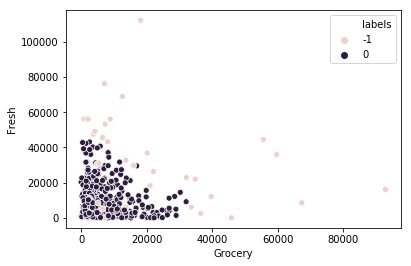

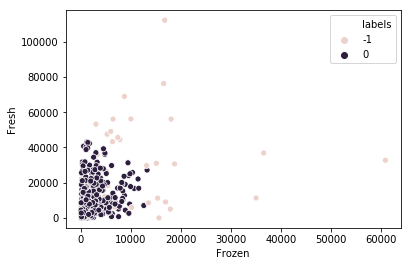

In [112]:
sns.scatterplot(store.Grocery, store.Fresh, hue=store.labels)
plt.show()

sns.scatterplot(store.Frozen, store.Fresh, hue=store.labels)
plt.show()

Text(0.5, 0, 'Grocery')

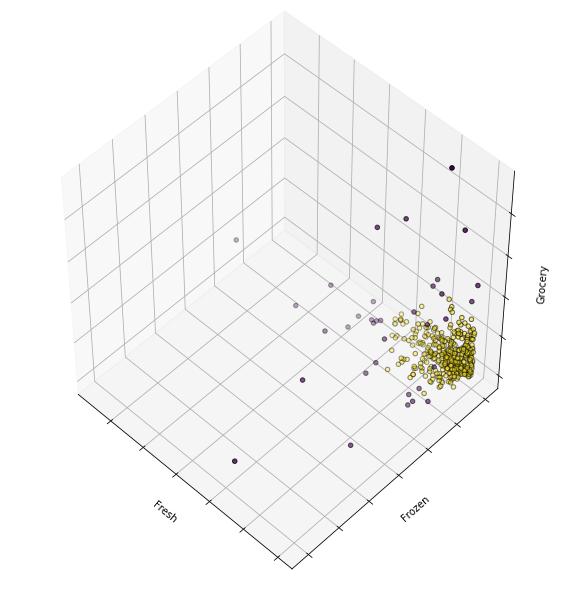

In [114]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(store.Fresh, store.Frozen, store.Grocery,
           c=store.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Grocery')

In [127]:
zillow = pd.read_csv('zillow_properties.csv')

In [128]:
zillow.shape

(167854, 68)

In [129]:
zillow = reindex_zillow(zillow)
drop_land_listings(zillow)
zillow.shape

(112689, 67)

In [130]:
convert_num_to_categorical(zillow)
convert_numerical_object_to_int(zillow)

,parcelid,logerror,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,transactiondate,yearbuilt,fips,latitude,longitude,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,3.0,2.0,1684.0,20160101,1959.0,6037.0,34280990.0,-118488536.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.168400,4.0,3.5,2263.0,20160101,2014.0,6059.0,33668120.0,-117677556.0,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.004000,2.0,3.0,2217.0,20160101,1940.0,6037.0,34136312.0,-118175032.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
4,14432541,-0.005000,4.0,2.5,2283.0,20160102,1981.0,6059.0,33485643.0,-117700234.0,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
5,11509835,-0.270500,4.0,4.0,3067.0,20160102,1982.0,6037.0,33870089.0,-118402768.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,6.037621e+13
6,12286022,0.044000,2.0,1.0,1297.0,20160102,1939.0,6037.0,33899475.0,-118212720.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13
10,10854446,0.382500,2.0,2.0,1417.0,20160103,1954.0,6037.0,34164671.0,-118477995.0,...,NaN,NaN,55396.0,105954.0,2015.0,50558.0,1443.69,NaN,NaN,6.037141e+13
11,11672170,-0.016100,5.0,4.0,3080.0,20160103,1995.0,6037.0,34072220.0,-118547322.0,...,NaN,NaN,559040.0,1090127.0,2015.0,531087.0,13428.94,NaN,NaN,6.037263e+13
12,10949761,0.034400,3.0,2.0,1484.0,20160103,1944.0,6037.0,34189804.0,-118339183.0,...,NaN,NaN,29551.0,70119.0,2015.0,40568.0,832.35,NaN,NaN,6.037311e+13
14,14148540,-0.045000,2.0,2.0,1367.0,20160103,1955.0,6059.0,33913333.0,-117914140.0,...,1.0,NaN,78565.0,254817.0,2015.0,176252.0,3192.28,NaN,NaN,6.059002e+13


In [131]:
zillow.drop(columns=['airconditioningtypeid',
 'airconditioningdesc',
 'architecturalstyletypeid',
 'architecturalstyledesc',
 'basementsqft',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'buildingclassdesc',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'heatingorsystemdesc',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidneighborhood',
 'storytypeid',
 'storydesc',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'typeconstructiondesc',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock'], axis=1, inplace=True)

In [132]:
zillow['yearbuilt'].fillna(1960, inplace=True)

In [133]:
zillow.dropna(axis=0, inplace=True)
zillow.isnull().sum()

parcelid                        0
logerror                        0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
transactiondate                 0
yearbuilt                       0
fips                            0
latitude                        0
longitude                       0
calculatedbathnbr               0
fullbathcnt                     0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
propertylandusedesc             0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
dtype: int64

In [134]:
zillow.drop(zillow.loc[zillow['regionidzip'] > 100000].index, inplace=True)
zillow.drop(zillow.loc[zillow['calculatedfinishedsquarefeet'] < 450].index, inplace=True)

In [135]:
def maggie_remove_outliers(df):
    keys = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet',
                          'structuretaxvaluedollarcnt','landtaxvaluedollarcnt']
    values = [(1,7), (1,7), (500,8000), (25000,2000000), (10000,2500000)]

    dictionary = dict(zip(keys, values))

    for key, value in dictionary.items():
        df = df[df[key] >= value[0]]
        df = df[df[key] <= value[1]]
    return df

In [137]:
zillow = maggie_remove_outliers(zillow)
zillow.describe()

,parcelid,logerror,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,transactiondate,yearbuilt,latitude,longitude,calculatedbathnbr,fullbathcnt,lotsizesquarefeet,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
count,1.071490e+05,107149.000000,107149.000000,107149.000000,107149.000000,1.071490e+05,107149.000000,1.071490e+05,1.071490e+05,107149.000000,107149.000000,1.071490e+05,107149.000000,107149.000000,1.071490e+05,1.071490e+05,1.071490e+05,107149.000000
mean,1.299494e+07,0.014433,3.319116,2.302355,1904.860521,2.016521e+07,1963.957116,3.402149e+07,-1.181903e+08,2.302355,2.235289,1.104254e+04,96577.995856,1.965207,1.830208e+05,4.799604e+05,2.969395e+05,6076.510695
std,2.528371e+06,0.161052,0.892458,0.935330,877.060043,4.955056e+03,22.476401,2.759448e+05,3.599116e+05,0.935330,0.912038,8.468260e+04,419.362372,3.182551,1.742176e+05,4.355873e+05,3.098105e+05,5268.387500
min,1.071174e+07,-4.655420,1.000000,1.000000,500.000000,2.016010e+07,1880.000000,3.334004e+07,-1.194753e+08,1.000000,1.000000,2.360000e+02,95982.000000,0.000000,2.500000e+04,3.615200e+04,1.009300e+04,49.080000
25%,1.150601e+07,-0.025195,3.000000,2.000000,1296.000000,2.016061e+07,1951.000000,3.382265e+07,-1.184003e+08,2.000000,2.000000,5.615000e+03,96213.000000,0.000000,7.989900e+04,2.050790e+05,8.528100e+04,2931.880000
50%,1.263826e+07,0.006000,3.000000,2.000000,1674.000000,2.016101e+07,1961.000000,3.402204e+07,-1.181427e+08,2.000000,2.000000,6.857000e+03,96424.000000,0.000000,1.319950e+05,3.710330e+05,2.174020e+05,4780.900000
75%,1.414618e+07,0.038913,4.000000,3.000000,2291.000000,2.017052e+07,1979.000000,3.418978e+07,-1.179237e+08,3.000000,3.000000,8.763000e+03,96996.000000,5.000000,2.201690e+05,6.000000e+05,3.950000e+05,7331.740000
max,1.629608e+08,4.445000,7.000000,7.000000,7985.000000,2.017092e+07,2016.000000,3.481877e+07,-1.175546e+08,7.000000,7.000000,6.971010e+06,97344.000000,15.000000,1.976957e+06,4.403314e+06,2.498951e+06,173218.070000
